In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional,GRU
import numpy as np

In [ ]:
# load dataset
dataset = read_csv('DATASETAIML3.csv', header=0, index_col=0)
values = dataset.values

In [ ]:
dataset.head()

,Date,Time,WS [m/s],DIR [°]
0,1201950000,0,6.99,37.08
1,1201950100,100,6.73,34.21
2,1201950200,200,6.55,31.23
3,1201950300,300,6.44,29.75
4,1201950400,400,6.33,28.83


In [ ]:
# dataset.dropna()
dataset.drop(dataset.columns[[1]], axis = 1, inplace = True)
print(dataset.head())

         Date  WS [m/s]  DIR [°]
0  1201950000      6.99    37.08
1  1201950100      6.73    34.21
2  1201950200      6.55    31.23
3  1201950300      6.44    29.75
4  1201950400      6.33    28.83


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#dataset['Day'] = pd.to_datetime(dataset['Day'])
dataset = dataset.set_index('Date')
values = dataset.values
encoder = LabelEncoder()
values[:, 1] = encoder.fit_transform(values[:, 1])
values = values.astype(float)
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
print()
print(scaled[:, 1])


[-1.41118727 -1.44509529 -1.48030291 ... -1.39405605 -1.44769451
 -1.4983793 ]


In [ ]:
n_input = 3
n_features = 2

reframed = series_to_supervised(scaled, n_input, 1)
#Splitting the dataset
values = reframed.values
train = values[:140000, :]
test = values[140000:, :]

n_obs = n_input * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140000, 6) 140000 (140000,)
(140000, 3, 2) (140000,) (35317, 3, 2) (35317,)


Epoch 1/50
1945/1945 - 30s - loss: 0.1016 - val_loss: 0.0742 - 30s/epoch - 15ms/step
Epoch 2/50
1945/1945 - 21s - loss: 0.0658 - val_loss: 0.0868 - 21s/epoch - 11ms/step
Epoch 3/50
1945/1945 - 17s - loss: 0.0646 - val_loss: 0.0993 - 17s/epoch - 9ms/step
Epoch 4/50
1945/1945 - 17s - loss: 0.0642 - val_loss: 0.0843 - 17s/epoch - 9ms/step
Epoch 5/50
1945/1945 - 17s - loss: 0.0634 - val_loss: 0.0810 - 17s/epoch - 9ms/step
Epoch 6/50
1945/1945 - 17s - loss: 0.0629 - val_loss: 0.0836 - 17s/epoch - 9ms/step
Epoch 7/50
1945/1945 - 18s - loss: 0.0625 - val_loss: 0.0824 - 18s/epoch - 9ms/step
Epoch 8/50
1945/1945 - 17s - loss: 0.0625 - val_loss: 0.0932 - 17s/epoch - 9ms/step
Epoch 9/50
1945/1945 - 17s - loss: 0.0621 - val_loss: 0.0818 - 17s/epoch - 9ms/step
Epoch 10/50
1945/1945 - 17s - loss: 0.0616 - val_loss: 0.0891 - 17s/epoch - 9ms/step
Epoch 11/50
1945/1945 - 17s - loss: 0.0612 - val_loss: 0.0812 - 17s/epoch - 9ms/step
Epoch 12/50
1945/1945 - 17s - loss: 0.0608 - val_loss: 0.0763 - 17s/epoc

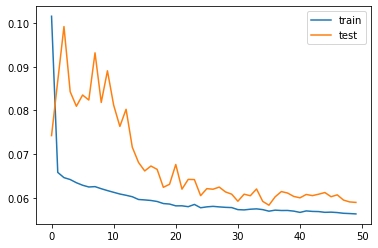

In [ ]:
model = Sequential()
model.add(GRU(75,return_sequences=True,input_shape=(n_input,n_features )))
model.add(GRU(units=30, return_sequences=True))
model.add(GRU(units=30))
#model.add(Dropout(0.4))
model.add(Dense(units=1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
print(yhat.shape)
print(len(yhat))
print(test_y.shape)

(35317, 1)
35317
(35317,)


In [ ]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.084


In [ ]:
prediction_copies = np.repeat(yhat, scaled.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
#inv_yhat = concatenate((prediction_copies, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(prediction_copies)
inv_yhat = inv_yhat[:,0]

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)

test_copies = np.repeat(test_y, scaled.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

inv_y = scaler.inverse_transform(test_copies)
inv_y = inv_y[:,0]

mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE: %.3f' % mape)

Test MSE: 0.036
Test RMSE: 0.189
Test MAE: 0.133
Test MAPE: 0.031


In [ ]:
#print(yhat)
print(inv_yhat)

[7.6422305 7.5997787 7.608736  ... 5.689145  6.0223393 6.192825 ]


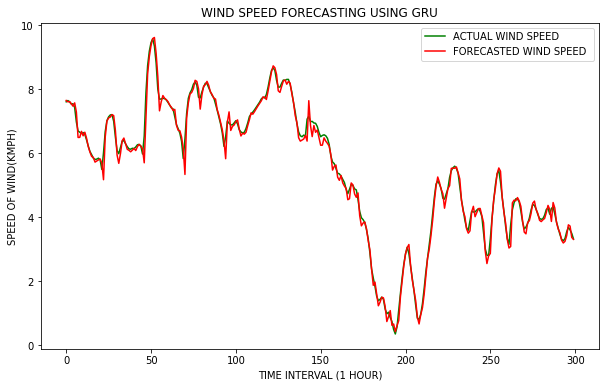

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(inv_y[:300], color= 'green',label = 'ACTUAL WIND SPEED ')
plt.plot(inv_yhat[:300] , color = 'red',label = 'FORECASTED WIND SPEED ')
plt.title("WIND SPEED FORECASTING USING GRU")
plt.xlabel("TIME INTERVAL (1 HOUR)")
plt.ylabel("SPEED OF WIND(KMPH)")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:
print(inv_y[:724])

[7.6  7.64 7.6  7.53 7.54 7.42 6.97 6.69 6.65 6.61 6.64 6.58 6.41 6.22
 6.05 5.95 5.84 5.8  5.81 5.84 5.79 5.49 6.01 6.67 7.01 7.13 7.19 7.2
 6.99 6.5  6.08 5.98 6.17 6.37 6.39 6.29 6.2  6.13 6.12 6.15 6.14 6.19
 6.26 6.27 6.22 5.97 6.53 7.88 8.73 9.18 9.45 9.57 9.34 8.82 8.   7.68
 7.69 7.71 7.7  7.66 7.58 7.5  7.41 7.38 7.13 6.89 6.76 6.62 6.37 5.83
 6.44 7.24 7.71 7.88 7.98 8.15 8.22 8.12 7.74 7.72 7.91 8.06 8.18 8.17
 8.04 7.92 7.8  7.73 7.54 7.34 7.13 6.91 6.63 6.21 6.51 7.   6.93 6.88
 6.88 6.94 7.01 6.91 6.73 6.66 6.63 6.65 6.77 6.94 7.14 7.22 7.28 7.35
 7.43 7.51 7.59 7.69 7.74 7.72 7.83 8.06 8.34 8.58 8.66 8.58 8.27 8.06
 8.06 8.18 8.28 8.27 8.3  8.3  8.14 7.9  7.57 7.28 6.92 6.66 6.54 6.51
 6.56 6.53 7.06 7.15 6.98 6.99 6.94 6.93 6.83 6.64 6.51 6.55 6.57 6.54
 6.46 6.27 5.91 5.72 5.67 5.52 5.37 5.35 5.28 5.18 5.08 4.87 4.73 4.87
 5.02 4.99 4.88 4.85 4.55 4.18 3.98 3.92 3.83 3.61 3.33 2.89 2.38 2.1
 1.84 1.53 1.39 1.43 1.5  1.43 1.13 0.98 1.03 0.86 0.74 0.49 0.35 0.57
 1.1  1.

In [ ]:
x=print(inv_yhat[:724])

[7.6422305  7.5997787  7.608736   7.540771   7.4640465  7.567119
 7.2823806  6.4868007  6.4900794  6.676915   6.5395317  6.650616
 6.4643946  6.2035856  6.031224   5.893248   5.8649416  5.7170196
 5.7528667  5.78571    5.816034   5.684127   5.1674466  6.4956107
 6.99906    7.097016   7.12555    7.199877   7.1704354  6.707454
 5.9372654  5.678793   5.9847817  6.386079   6.4682226  6.2881427
 6.116912   6.0863767  6.0394206  6.092027   6.142667   6.0776567
 6.2028594  6.269599   6.2151575  6.1271915  5.695495   7.063726
 8.463758   9.0139475  9.35985    9.575452   9.609734   9.117978
 8.392472   7.318459   7.5981946  7.795829   7.7132893  7.667709
 7.6073895  7.496714   7.4295325  7.3288107  7.3643208  6.870266
 6.7111983  6.6971416  6.501617   6.1400685  5.3317885  7.0972342
 7.5655017  7.8448043  7.8947496  8.018061   8.272179   8.236658
 8.004898   7.3722916  7.8135886  8.086847   8.135482   8.23845
 8.115825   7.906501   7.8298655  7.707069   7.6881433  7.3592105
 7.1835046  6.963525

In [ ]:
from numpy import savetxt
savetxt('/content/drive/MyDrive/Research Paper/M_GRU.csv', inv_yhat, delimiter='/n')
open("M_GRU.csv")

FileNotFoundError: ignored

In [ ]:
from numpy import savetxt
savetxt('newa.csv', inv_y, delimiter='/n')
open("newa.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')